# MetOpts Lab1

imports

In [2]:
import matplotlib.pyplot as plot
import numpy as np
import math
import pandas as pd

## Задание 1. 
Реализуйте градиентный спуск с постоянным шагом (learning rate). Исследовать сходимость при различных значениях шага.

---

В качестве примера выберем следующую функцию (`f`), а также сразу посчитаем ее градиент (`df`).

In [3]:
def f(x, y):
    return 2 * (x + 3) ** 2 + 4 * (y + 5) ** 2


def df(x, y):
    return 4 * (x + 3), 8 * (y + 5)

Построим график поверхности нашей функции в области, где мы будем искать минимум.

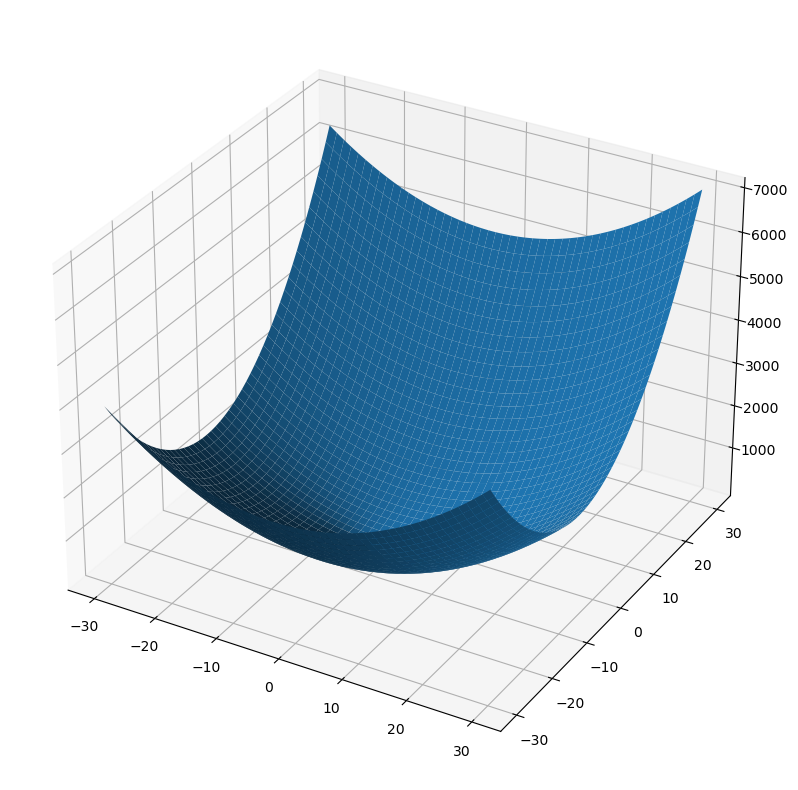

In [4]:
plot.rcParams["figure.figsize"] = (20, 10)
t = np.linspace(-30, 30, 1000)
X, Y = np.meshgrid(t, t)

ax = plot.figure().add_subplot(projection="3d")
ax.plot_surface(X, Y, f(X, Y))
plot.show()

Реализуем градиентный спуск с постоянным шагом. Размер шага будем передавать как аргумент функции `learning rate`. Для последующих заданий функцию изменения шага будем передавать в переменной `lr_func`.

In [5]:
def graddesc(cur_point, learning_rate, max_steps, grad_func, lr_func):
    data = [cur_point]

    for step_num in range(max_steps):
        cur_point = [cur_point[0] - learning_rate * grad_func(*cur_point)[0], cur_point[1] - learning_rate * grad_func(*cur_point)[1]]
        data.append(cur_point)
        learning_rate = lr_func(step_num, learning_rate)

    return np.array(data)

Для константной функции напишем следующую функцию, возращающую константный `learning rate`

In [6]:
def const_lr_func(step, lr):
    return lr

Объявим константы. А именно количество шагов `STEPS`, стартовое значение `START_POINT` и набор различных значений шага `SAMPLE_LRs`, на которых будем запускать градиентный спуск 

In [7]:
STEPS = 100
START_POINT = [-20, 10]
SAMPLE_LRs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1] 

Реализуем функцию, строящую контур спуска.

In [8]:
def draw_plot(ax, points, func,  title = ""): 
    ax.plot(points[:, 0], points[:, 1], "o-")
    ax.contour(X, Y, func(X, Y), levels=sorted(list(set([f(*p) for p in points]))))
    if title:
        ax.set_title(title)

Запустим градиентный спуск с различными константными значениями.

In [9]:
results = []
best_min = 10**9 + 7
best_conv = []

for lr in SAMPLE_LRs:
    conv = graddesc(START_POINT, lr, STEPS, df, const_lr_func)
    results.append(f(*conv[-1]))

    if results[-1] < best_min:
        best_min = results[-1]
        best_conv = conv

Рассмотрим получившиеся результаты.

In [10]:
print("Stats\n   LR   RES")
for lr, res in zip(SAMPLE_LRs, results):
    print(f"{lr:5}   {res:e}")

print(f"Best: {best_conv[-1]}")

Stats
   LR   RES
 0.05   2.398420e-17
  0.1   3.944305e-31
 0.15   0.000000e+00
  0.2   3.155444e-30
 0.25   9.000000e+02
  0.3   1.513037e+32
  0.5   2.390526e+98
    1   9.415654e+171
Best: [-3. -5.]


Заметим, что при размере шага `0.15`, градиентный спуск находит точный минимум в точке `(-3, -5)` (убедиться в том, что это действительно минимум несложно). Различные другие размеры шага, дают результат хуже. 

Кроме того, мы можем заметить, что при `LR = 0.25` происходит аномальное повидение, вместо того, чтобы спускаться к минимуму, значение скачет между двумя точками. Это поведение несложно объясняется анализом нашей функции. Это же значение `LR` также является и "пограничной точкой". Все `LR` меньше ее ведут к схождению к минимуму функции, а при значениях больше получаемый результат увеличивается, уходя в бесконечность, что можно заметить на примере `LR = 0.3`, `LR = 0.5` и `LR = 1`.    

Покажем наглядно поведение градиентного спуска при различных значениях `LR` с помощью контуров.

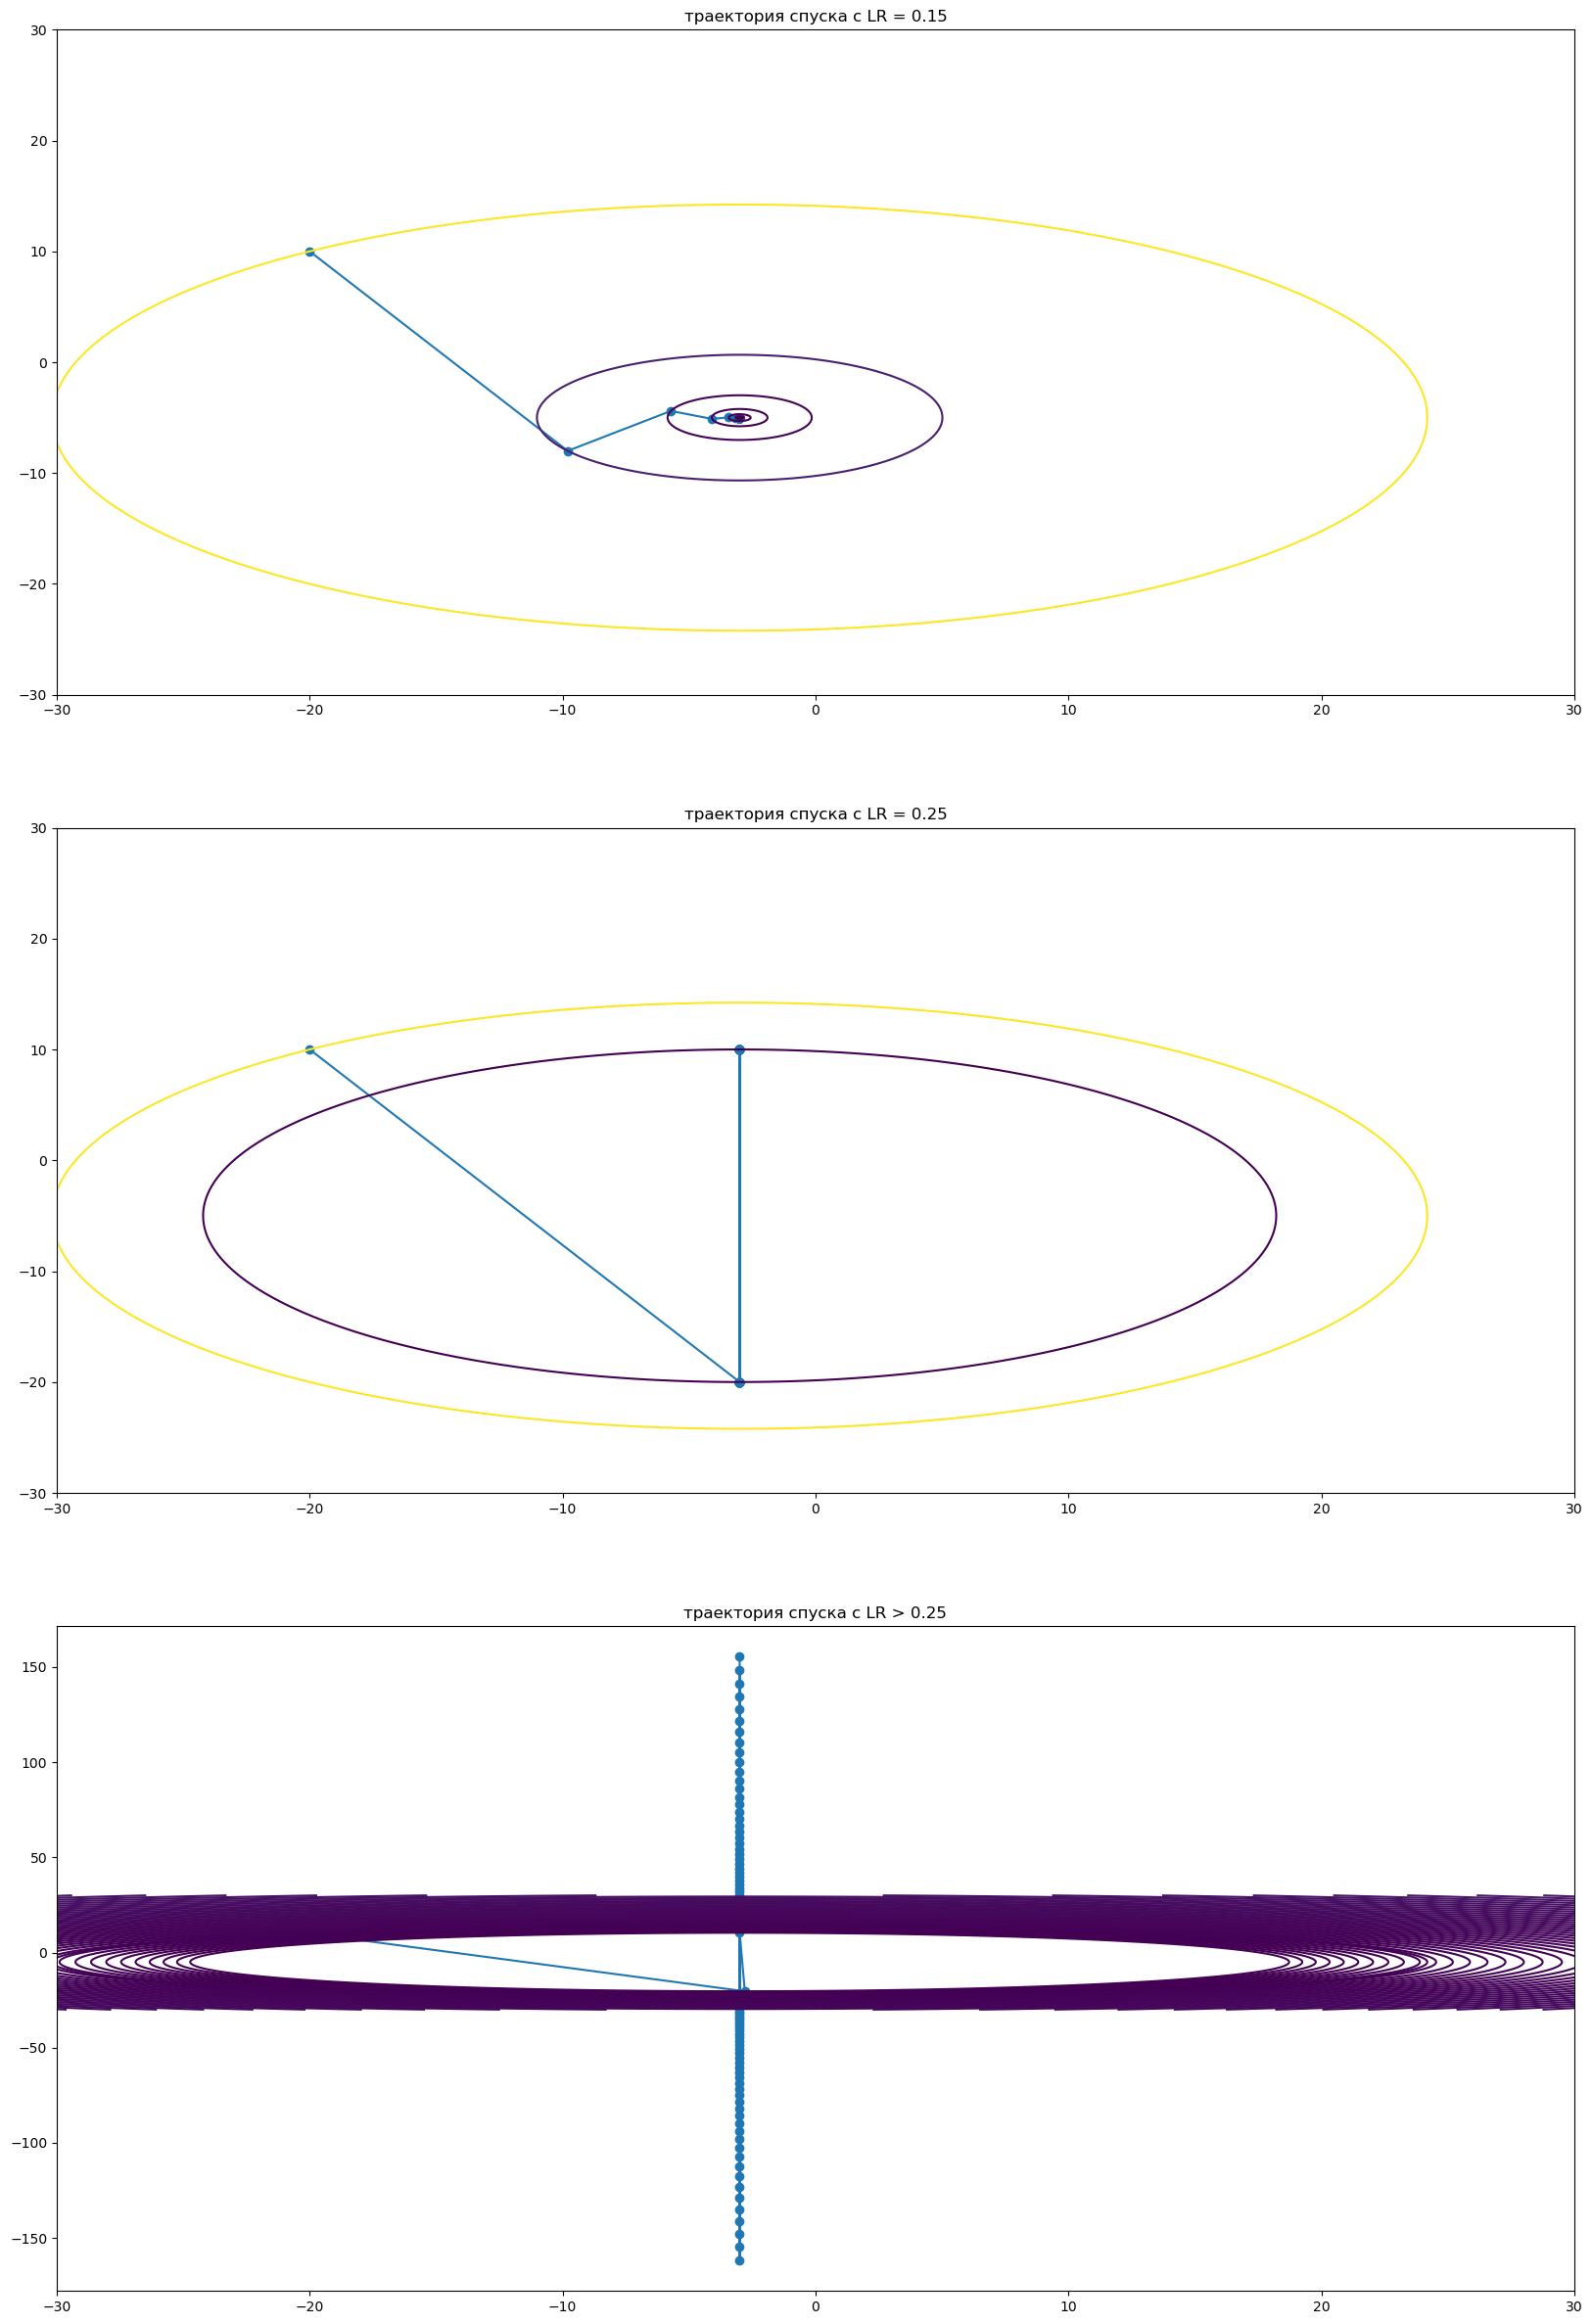

In [11]:
plot.rcParams["figure.figsize"] = (20, 10)
t = np.linspace(-30, 30, 1000)
X, Y = np.meshgrid(t, t)
fig, (ax1,ax2,ax3) = plot.subplots(3,1)
fig.set_size_inches(20,30)
draw_plot(ax1,graddesc(START_POINT, 0.15, STEPS, df, const_lr_func), f, "траектория спуска с LR = 0.15")
draw_plot(ax2,graddesc(START_POINT, 0.25, STEPS, df, const_lr_func), f, "траектория спуска с LR = 0.25")
draw_plot(ax3,graddesc(START_POINT, 0.253, STEPS, df, const_lr_func), f, "траектория спуска с LR > 0.25")
plot.show()


## Задание 2. 
Подберите функцию изменения шага (learning rate scheduling), чтобы улучшить сходимость. Например, экспоненциальную или ступенчатую.

---

В качестве примеров возьмём ступенчатую (`step_lr_func`) функцию изменения шага. Выберем следующие константы `DROP` - насколько будет уменьшаться размер шага, `STEPS_DROP` - количество шагов, через которое происходит изменение шага. 

In [12]:
DROP = 0.995
STEPS_DROP = 5

def step_lr_func(step, lr):
    return lr * (DROP ** math.floor(step/STEPS_DROP))

Посмотрим как изменяется размер шага при разных функциях.

In [13]:
STEPS = 100
CONST_INIT_LR = 0.15
STEP_INIT_LR = 0.2

const_lr_data = [CONST_INIT_LR]
step_lr_data = [STEP_INIT_LR]

for i in range(4 * STEPS):
    const_lr_data.append(const_lr_func(i, const_lr_data[0]))
    step_lr_data.append(step_lr_func(i, step_lr_data[0]))

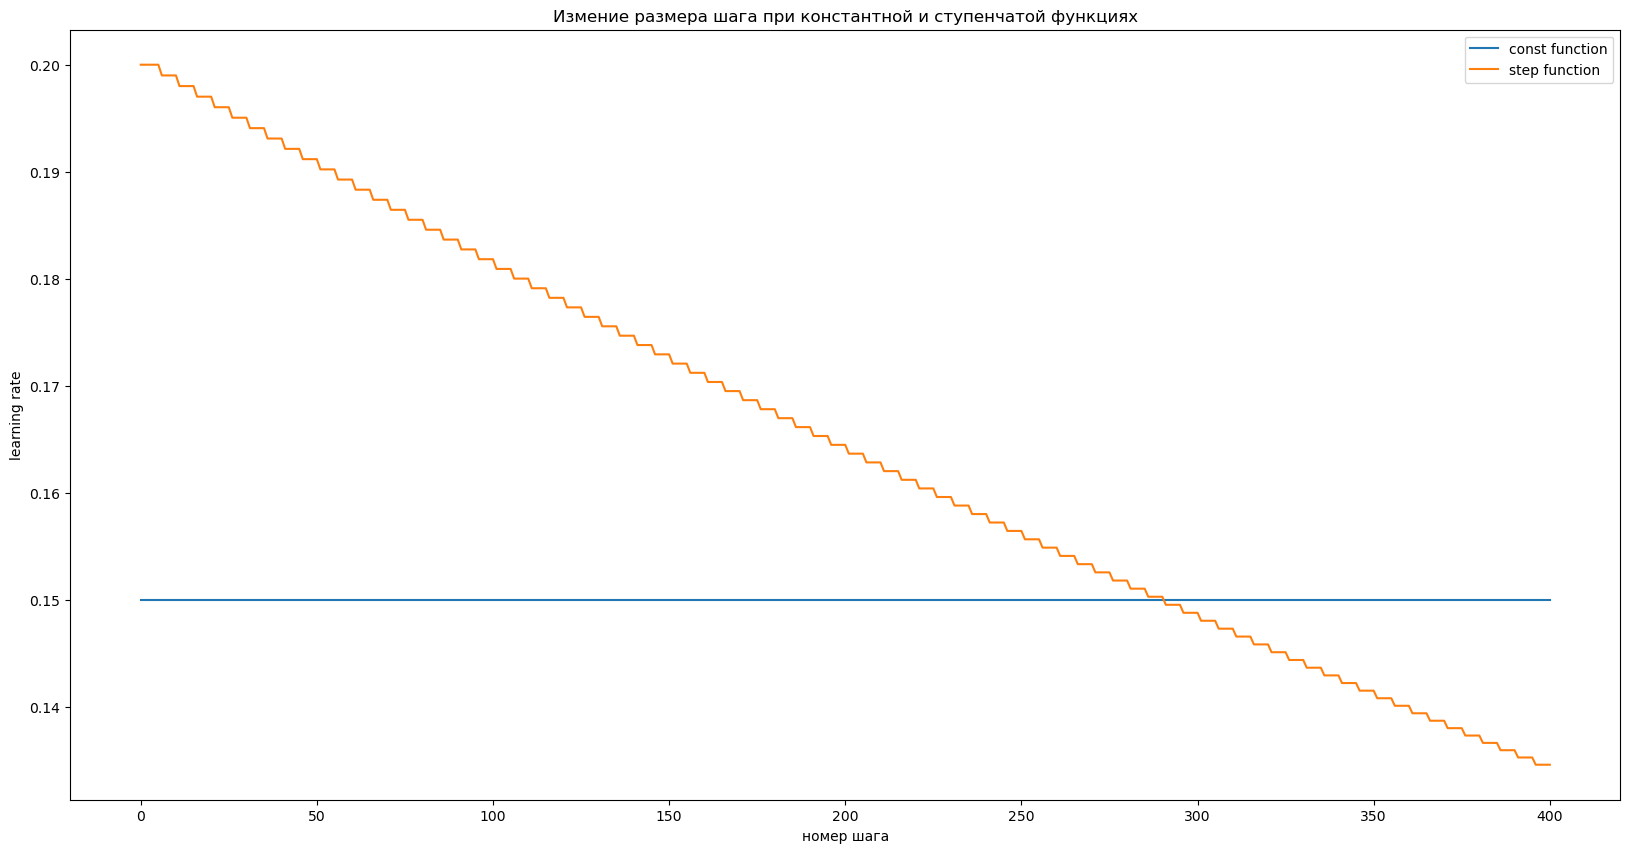

In [14]:
plot.plot(const_lr_data, label="const function")
plot.plot(step_lr_data, label="step function")
plot.title("Измение размера шага при константной и ступенчатой функциях")
plot.ylabel("learning rate")
plot.xlabel("номер шага")
plot.legend()
plot.show()

Посмотрим как быстро ступенчатая и константная функция находят минимум. 

In [15]:
step_results = graddesc(START_POINT, STEP_INIT_LR, STEPS, df, step_lr_func)
const_results = graddesc(START_POINT, CONST_INIT_LR, STEPS, df, const_lr_func)

print(f" I   STEP FUN       CONST FUN")
for i, (s, c) in enumerate(zip(step_results[:50:2], const_results[:50:2])):
    print(f"{i * 2:2}   {f(*s):e}   {f(*c):e}")

 I   STEP FUN       CONST FUN
 0   1.478000e+03   1.478000e+03
 2   1.175648e+02   1.623680e+01
 4   1.511802e+01   3.811021e-01
 6   1.959106e+00   9.700917e-03
 8   2.341996e-01   2.482550e-04
10   2.510002e-02   6.355187e-06
12   2.339883e-03   1.626926e-07
14   1.733841e-04   4.164929e-09
16   1.012068e-05   1.066222e-10
18   4.184075e-07   2.729528e-12
20   1.158526e-08   6.987591e-14
22   2.004788e-10   1.788823e-15
24   1.830042e-12   4.579388e-17
26   8.058552e-15   1.172324e-18
28   1.260736e-17   3.001153e-20
30   4.854225e-21   7.682756e-22
32   2.067952e-25   1.967097e-23
34   0.000000e+00   5.036482e-25
36   0.000000e+00   1.292194e-26
38   0.000000e+00   3.317160e-28
40   0.000000e+00   9.860761e-30
42   0.000000e+00   3.944305e-31
44   0.000000e+00   0.000000e+00
46   0.000000e+00   0.000000e+00
48   0.000000e+00   0.000000e+00


По результатам заметим, что ступенчатая функция обгоняет константную и находит минимум (с точностью до 1e-32) быстрее на 34 шаге, в то время как константная функция находит его только на 44 шаге.

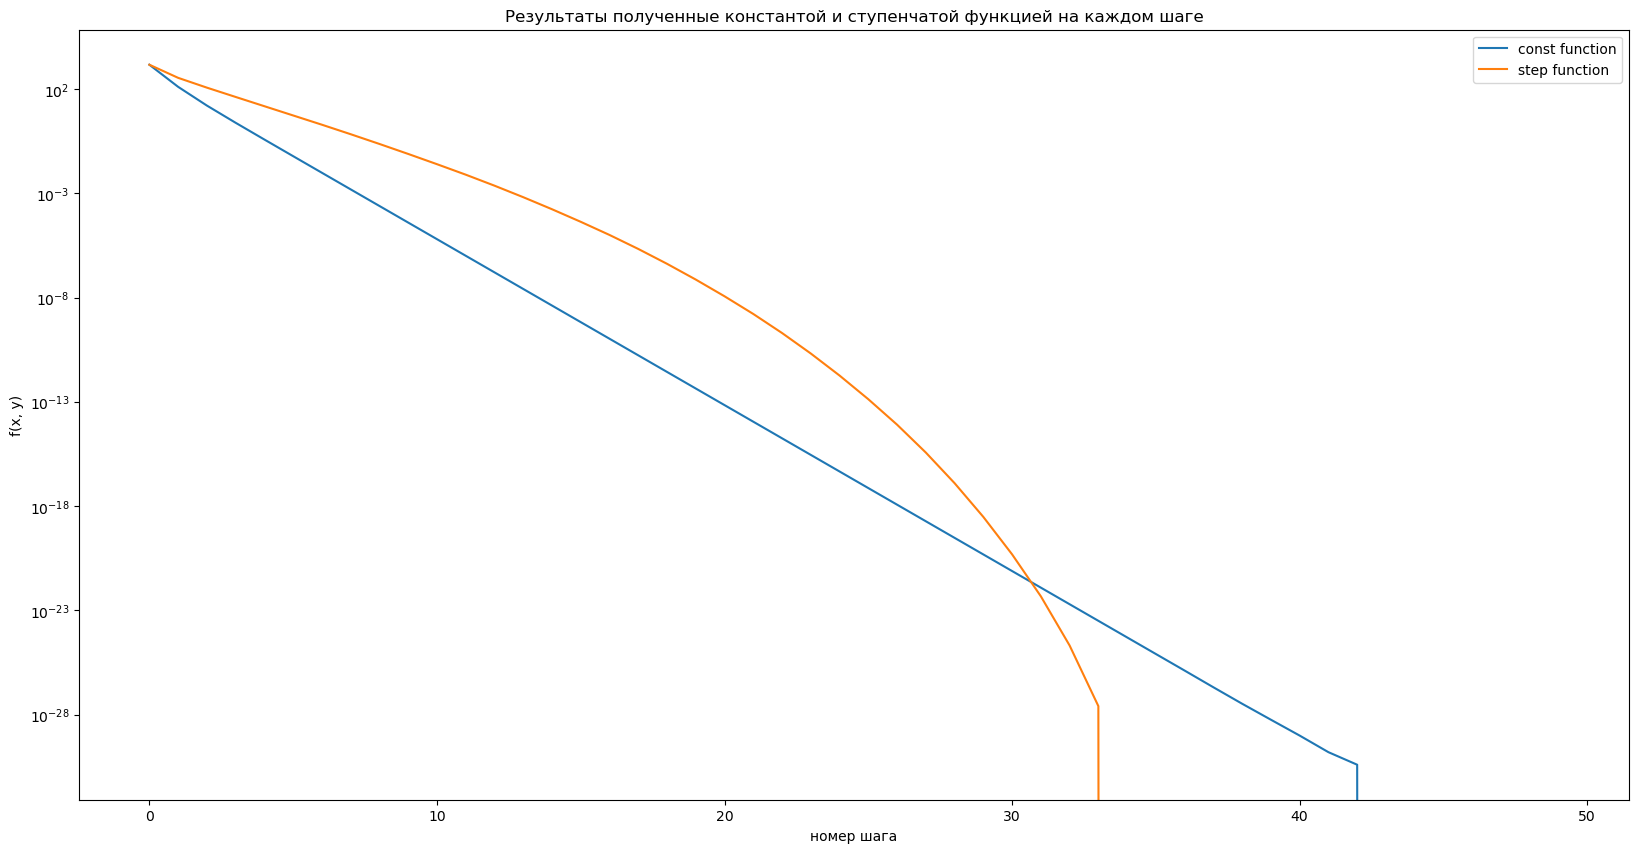

In [16]:
plot.plot(list(map(lambda x: f(*x), const_results[:50])), label="const function")
plot.plot(list(map(lambda x: f(*x), step_results[:50])), label="step function")
plot.yscale('log')
plot.title("Результаты полученные константой и ступенчатой функцией на каждом шаге")
plot.xlabel("номер шага")
plot.ylabel("f(x, y)")
plot.legend()
plot.show()


На данном логорифмическом графике видно, что константная функция изначально находила более точный результат, но затем ступенчатая "обогнала" и нашла точный результат быстрее.   

## Задание 3.
Реализовать какой-нибудь метод одномерного поиска (дихотомии, метод Фибоначчи, метод золотого сечения) и градиентный спуск на его основе. Сравнить эффективность с точки зрения количества вычислений минимизируемой функции и ее градиентов.

---

Реализуем градиентный спуск с поиском оптимального `learning rate` методом дихотомии.

In [17]:
func_calls = 0
grad_calls = 0

def dicho_graddesc(cur_point, max_steps, func, grad_func, eps = 5e-3):
    global func_calls
    global grad_calls
    cur_point = np.array(cur_point)
    data = []

    for i in range(max_steps):
        data.append(cur_point)
        grad = np.array(grad_func(*cur_point))
        grad_calls += 1

        l = 1e-10
        r = 1

        while r - l > eps / 4:
            m = (l + r) / 2

            if func(*(cur_point - (m - eps) * grad)) <= func(*(cur_point - (m + eps) * grad)):
                r = m
            else:
                l = m

            func_calls += 2
        
        cur_point = cur_point - l * grad

    return np.array(data)

Количество вызовов функции и ее градиента в реализации градиентного спуска на основе одномерного поиска методом дихотомии

In [18]:
dicho_results = dicho_graddesc(START_POINT, STEPS, f, df)
print(f"dicho_graddesc function calls: {func_calls}")
print(f"dicho_graddesc gradient calls: {grad_calls}")

dicho_graddesc function calls: 2000
dicho_graddesc gradient calls: 100


Посмотрим и сравним сходимость градиентного спуска с использованием дихотомии и градиентного спуска с использованием ступенчатого метода.

In [19]:
print(f" I   STEP FUN       DICHO FUN")
for i, (s, c) in enumerate(zip(step_results[:50:2], dicho_results[:50:2])):
    print(f"{i * 2:2}   {f(*s):e}   {f(*c):e}")

 I   STEP FUN       DICHO FUN
 0   1.478000e+03   1.478000e+03
 2   1.175648e+02   1.002156e+01
 4   1.511802e+01   6.798030e-02
 6   1.959106e+00   4.610157e-04
 8   2.341996e-01   2.914791e-06
10   2.510002e-02   1.707582e-08
12   2.339883e-03   9.176509e-11
14   1.733841e-04   4.482902e-13
16   1.012068e-05   1.970910e-15
18   4.184075e-07   7.674893e-18
20   1.158526e-08   2.612376e-20
22   2.004788e-10   8.894575e-23
24   1.830042e-12   3.029620e-25
26   8.058552e-15   9.277004e-28
28   1.260736e-17   4.259849e-29
30   4.854225e-21   1.577722e-30
32   2.067952e-25   0.000000e+00
34   0.000000e+00   0.000000e+00
36   0.000000e+00   0.000000e+00
38   0.000000e+00   0.000000e+00
40   0.000000e+00   0.000000e+00
42   0.000000e+00   0.000000e+00
44   0.000000e+00   0.000000e+00
46   0.000000e+00   0.000000e+00
48   0.000000e+00   0.000000e+00


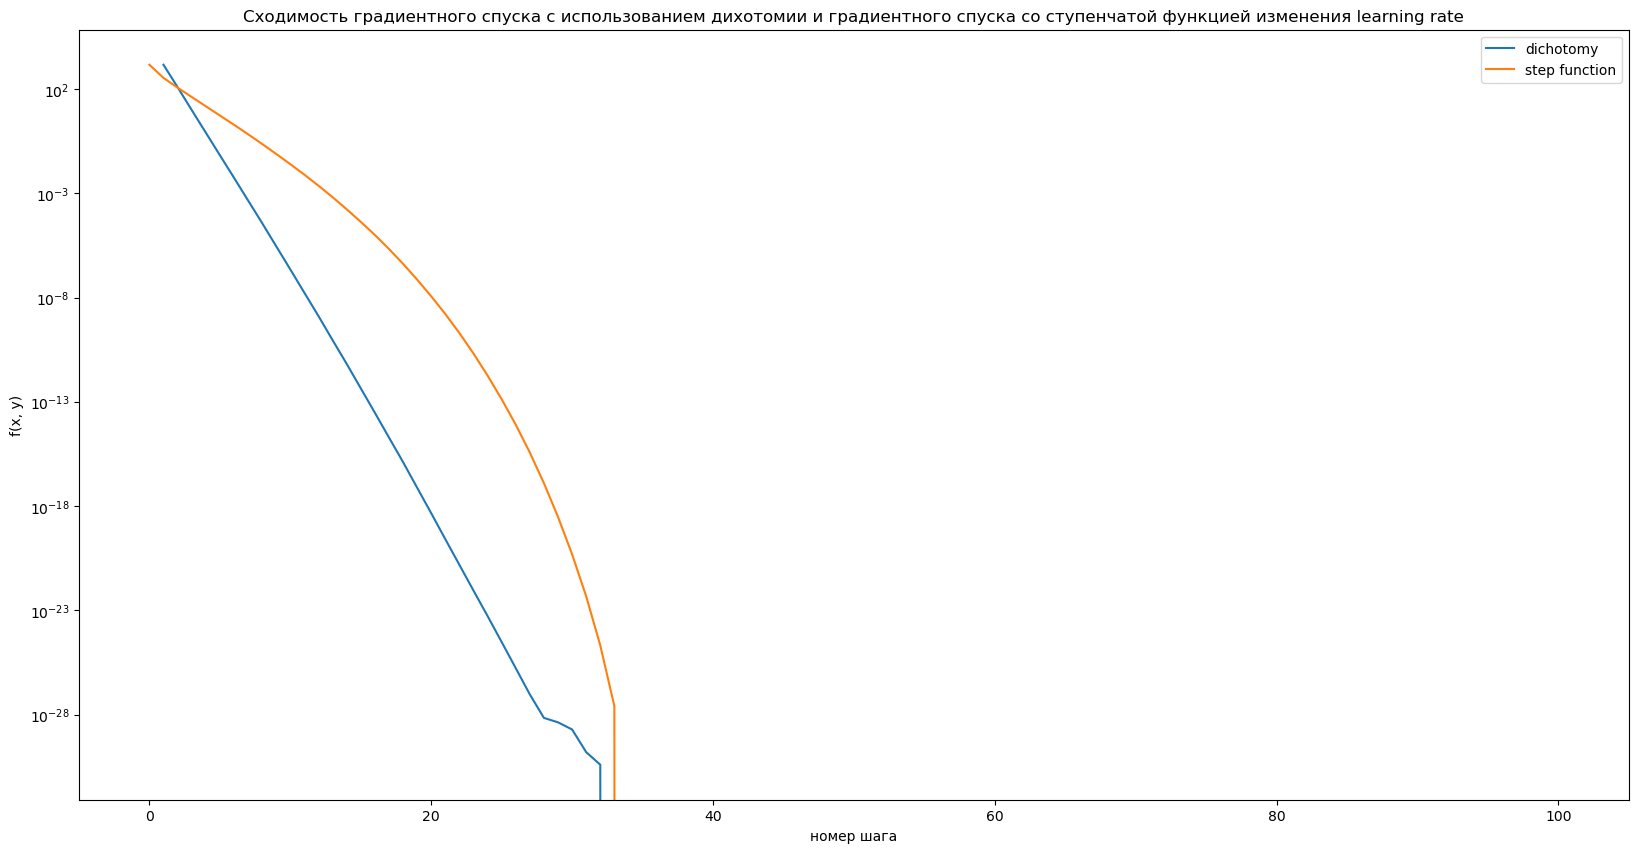

In [20]:
plot.plot(np.arange(1, STEPS + 1), [f(*p) for p in dicho_results],label="dichotomy")
plot.plot(np.arange(STEPS + 1), [f(*p) for p in step_results],label="step function")
plot.yscale('log') # logarithmic scale
plot.legend()
plot.xlabel("номер шага")
plot.ylabel("f(x, y)")
plot.title("Сходимость градиентного спуска с использованием дихотомии и градиентного спуска со ступенчатой функцией изменения learning rate")
plot.show()

Как мы можем заметить, градиентный спуск на основе дихотомии показывает результаты значительно лучше градиентного спуска со ступенчатой функцией изменения шага. Однако за выигрыш в сходимости мы платим количеством вызовов функции и ее градиента. Так мы дополнительно вычисляем функцию дополнительно 2000 раз, а ее градиент 100 раз. 

## Задание 5.

Проанализируйте траекторию градиентного спуска для нескольких квадратичных функций: придумайте две-три квадратичные двумерные функции, на которых работа метода будет отличаться, нарисуйте графики с линиями уровня функций и траекториями методов.  
Попробуйте ответить на следующий вопрос: Как отличается поведение метода в зависимости от ~~числа обусловленности функции,~~ выбора начальной точки и стратегии выбора шага? 

---

Придумаем еще 2 функции `f1` и `f2`, посчитаем их градиенты `df1` и `df2`, и построим графики

In [21]:
def f1(x, y):
    return 0.75 * (x - 2) ** 2 + 1.8 * (y + 6) ** 2

def df1(x, y):
    return 1.5 * (x - 2), 3.6 * (y + 6)


def f2(x, y):
    return (x + 7.5) ** 2 + (y - 2.4) ** 2

def df2(x, y):
    return 2 * (x + 7.5), 2 * (y - 2.4)

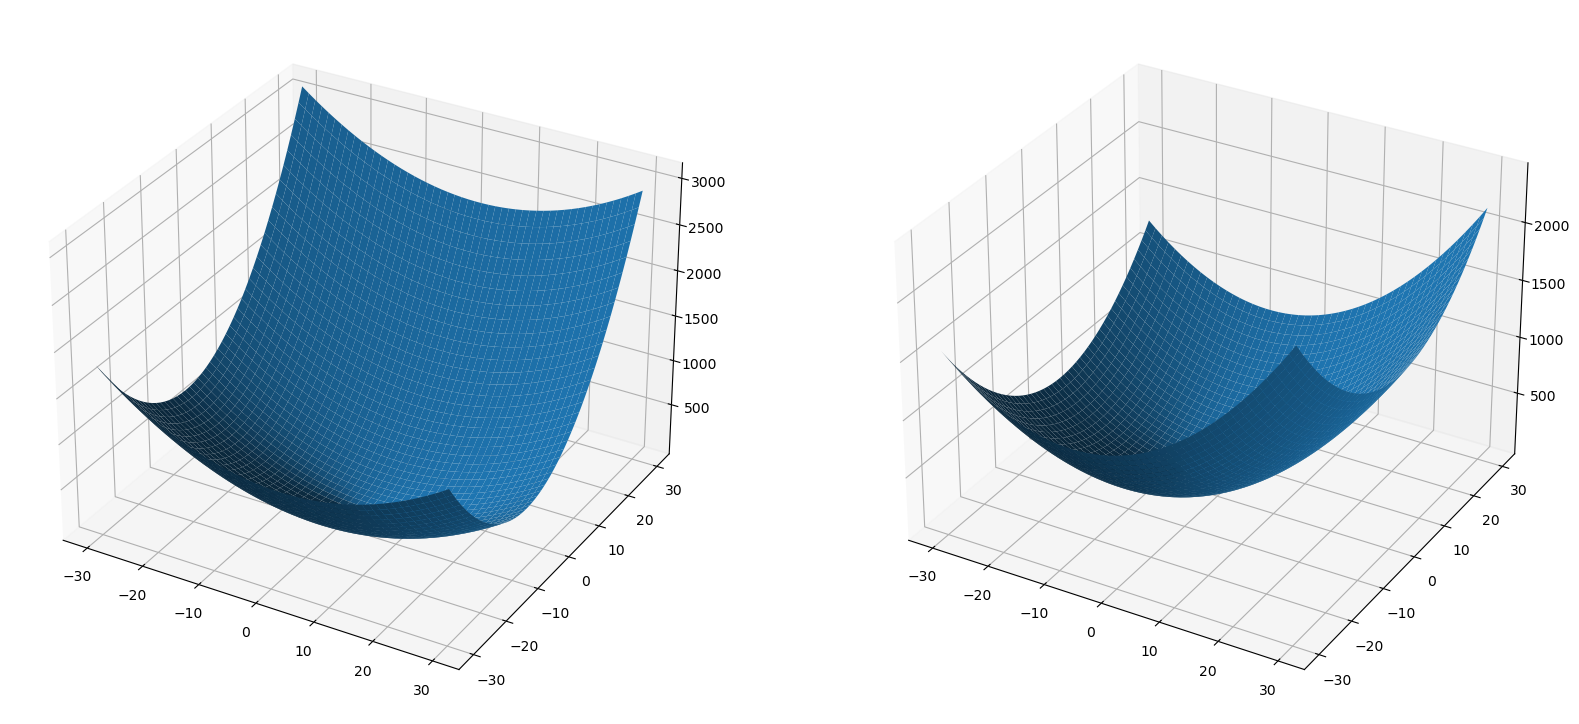

In [22]:
fg = plot.figure()
fg.add_subplot(1, 2, 1, projection="3d").plot_surface(X, Y, f1(X, Y))
fg.add_subplot(1, 2, 2, projection="3d").plot_surface(X, Y, f2(X, Y))

plot.show()

Запустим на обеих функциях градиентный спуск двумя методами - градиентным спуском с дихотомией и со ступенчатым изменением шага. Построим траекторию градиентного спуска для каждой функции и для каждого способа.

In [23]:
X, Y = np.meshgrid(np.linspace(-20, 20, 1000), np.linspace(-20, 20, 1000))

START_POINT = [10, 5]
STEPS = 100

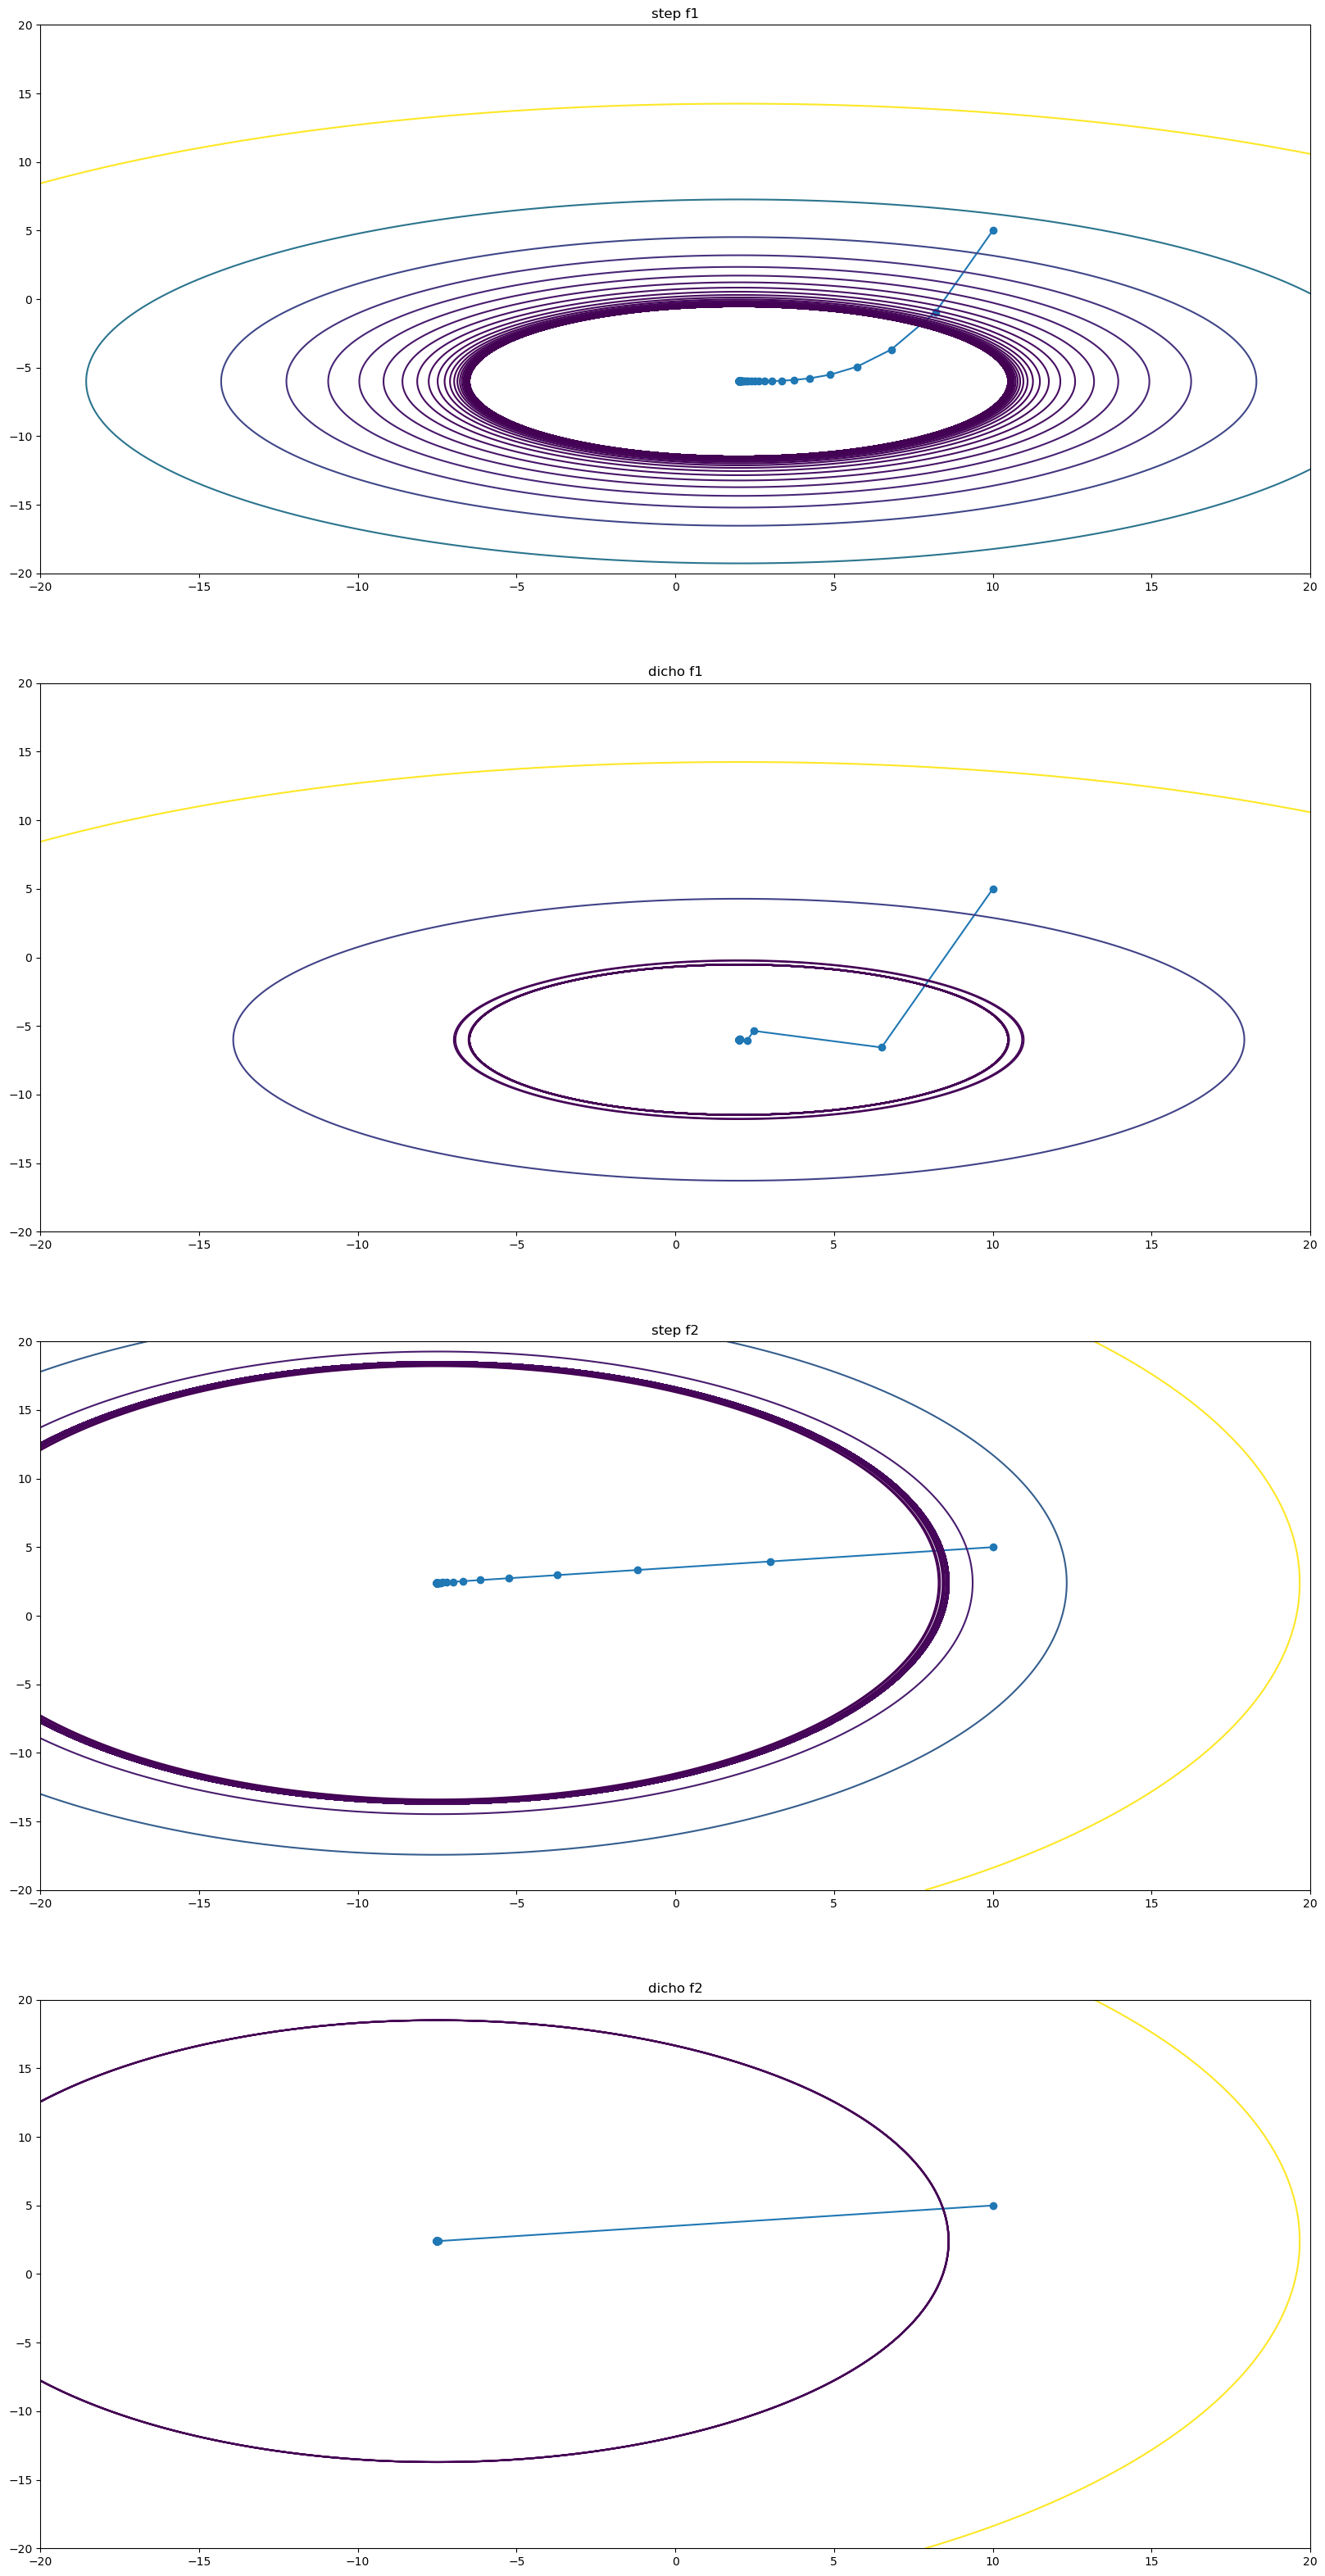

In [24]:
fig, (ax1, ax2, ax3, ax4) = plot.subplots(4, 1)
fig.set_size_inches(20, 40)

draw_plot(ax1, graddesc(START_POINT, 0.15, STEPS, df1, step_lr_func), f1, "step f1")
draw_plot(ax2, dicho_graddesc(START_POINT, STEPS, f1, df1), f1, "dicho f1")
draw_plot(ax3, graddesc(START_POINT, 0.2, STEPS, df2, step_lr_func), f2, "step f2")
draw_plot(ax4, dicho_graddesc(START_POINT, STEPS, f2, df2), f2, "dicho f2")
plot.show()

По получившимя графикам траекторий видно, что градиентный спуск на основе одномерного поиска методом дихотомии сходится быстрее, чем градиентный спуск с ступенчатой функцией изменения шага.

Теперь исследуем поведение методов в зависимости от выбора начальной точки. 

Будем собирать данные с шестью различных начльный точек, запуская два метода градиентного спуска, с двумя функциями. 

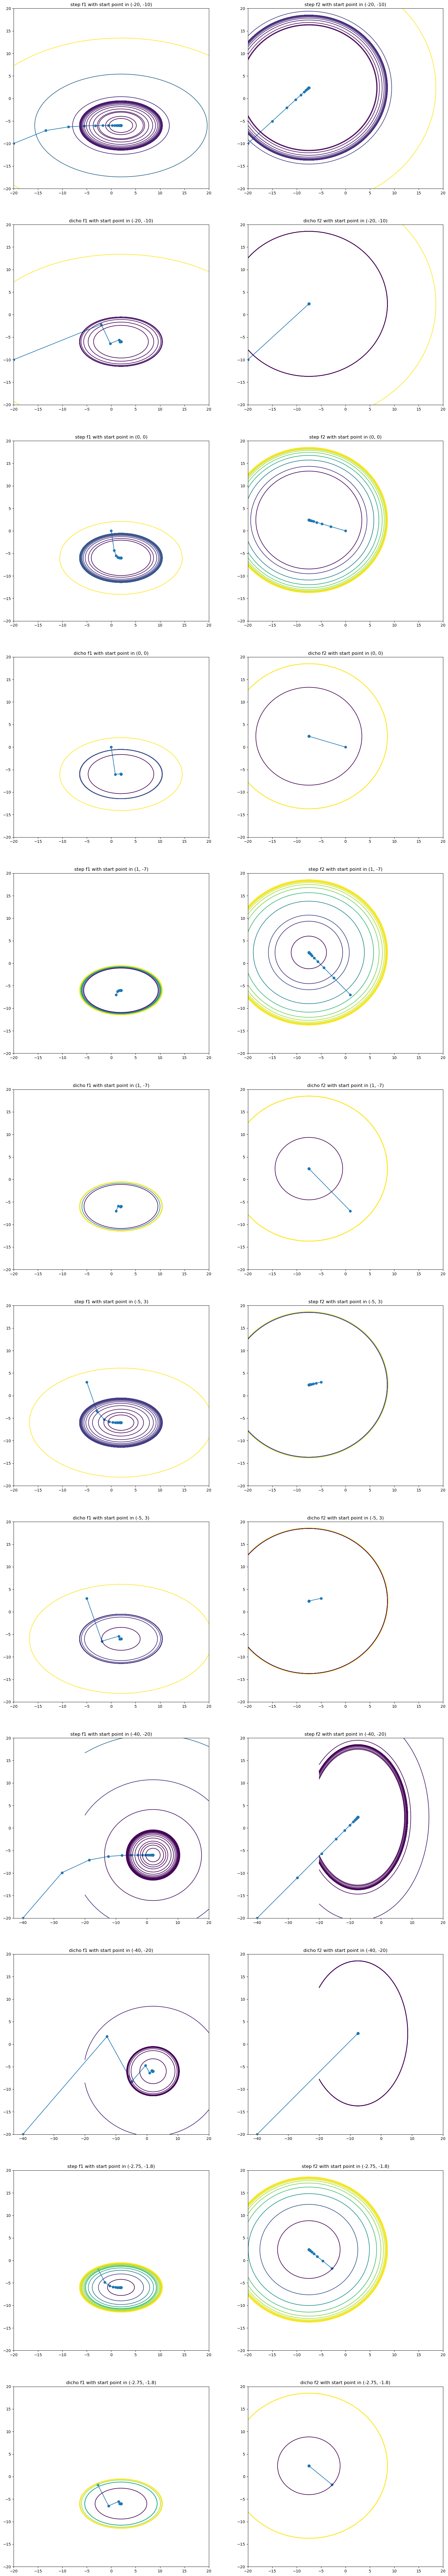

In [25]:
START_POINTS = [(-20, -10), (0, 0), (1, -7), (-5, 3), (-40, -20), (-2.75, -1.8)]

data = []
ptss = []

fig, axs = plot.subplots(12, 2)
fig.set_size_inches(20, 120)

# start point index
for spi in range(6):
    # j = 0 -> f1 + step
    #     1 -> f2 + step
    #     2 -> f1 + dicho
    #     3 -> f2 + dicho
    for j in range(4):
        data.append([])
        data[spi*4 + j].append(START_POINTS[spi])

        if j % 2:
            data[spi*4 + j].append("f2")
            dist = np.hypot(*(np.array([-7.5, 2.4]) - START_POINTS[spi]))
            data[spi*4 + j].append(dist)
        else:
            data[spi*4 + j].append("f1")
            dist = np.hypot(*(np.array([2, -6]) - START_POINTS[spi]))
            data[spi*4 + j].append(dist)
            
        if j < 2:
            data[spi*4 + j].append("step fun")
            if j % 2:
                ptss.append(graddesc(START_POINTS[spi], 0.2, STEPS, df2, step_lr_func))
                draw_plot(axs[2 * spi][1], ptss[-1], f2, f"step f2 with start point in {START_POINTS[spi]}")
            else:
                ptss.append(graddesc(START_POINTS[spi], 0.2, STEPS, df1, step_lr_func))
                draw_plot(axs[2 * spi][0], ptss[-1], f1, f"step f1 with start point in {START_POINTS[spi]}")
        else:
            data[spi*4 + j].append("dichotomy")
            if j % 2:
                ptss.append(dicho_graddesc(START_POINTS[spi], STEPS, f2, df2))
                draw_plot(axs[2 * spi + 1][1], ptss[-1], f2, f"dicho f2 with start point in {START_POINTS[spi]}")
            else:
                ptss.append(dicho_graddesc(START_POINTS[spi], STEPS, f1, df1))
                draw_plot(axs[2 * spi + 1][0], ptss[-1], f1, f"dicho f1 with start point in {START_POINTS[spi]}")
        
        if j % 2:
            data[spi*4 + j].append(f2(*ptss[-1][-1]))
            
        else:
            data[spi*4 + j].append(f1(*ptss[-1][-1]))
plot.show()


Рассмотрим подробнее данные всех тестов. Для этого представим получившиеся данные в виде таблицы.   
`coords` - координаты начальной точки   
`function` - рассматриваемая функция   
`dist` - расстояние от начальной точки до точки в которой находится минимум    
`method` - рассматриваемый метод градиентного спуска   
`result` - найденный минимум функции   


In [26]:
    
pd.DataFrame(data, columns=["coords","function","dist","method","result"]).sort_values(["method","function","dist"]).reset_index(drop=True)


coords function       dist     method        result
0         (1, -7)       f1   1.414214  dichotomy  1.811915e-30
1          (0, 0)       f1   6.324555  dichotomy  1.456927e-30
2   (-2.75, -1.8)       f1   6.340544  dichotomy  0.000000e+00
3         (-5, 3)       f1  11.401754  dichotomy  0.000000e+00
4      (-20, -10)       f1  22.360680  dichotomy  0.000000e+00
5      (-40, -20)       f1  44.271887  dichotomy  3.231865e-30
6         (-5, 3)       f2   2.570992  dichotomy  0.000000e+00
7   (-2.75, -1.8)       f2   6.340544  dichotomy  0.000000e+00
8          (0, 0)       f2   7.874643  dichotomy  0.000000e+00
9         (1, -7)       f2  12.673200  dichotomy  0.000000e+00
10     (-20, -10)       f2  17.607101  dichotomy  0.000000e+00
11     (-40, -20)       f2  39.471635  dichotomy  0.000000e+00
12        (1, -7)       f1   1.414214   step fun  2.093821e-13
13         (0, 0)       f1   6.324555   step fun  8.375286e-13
14  (-2.75, -1.8)       f1   6.340544   step fun  4.724185e-12
15        (-5, 3)       f1  11.401754   step fun  1.025973e-11
16     (-20, -10)       f1  22.360680   step fun  1.013410e-10
17     (-40, -20)       f1  44.271887   step fun  3.693501e-10
18        (-5, 3)       f2   2.570992   step fun  1.657712e-17
19  (-2.75, -1.8)       f2   6.340544   step fun  1.008232e-16
20         (0, 0)       f2   7.874643   step fun  1.555139e-16
21        (1, -7)       f2  12.673200   step fun  4.027913e-16
22     (-20, -10)       f2  17.607101   step fun  7.774690e-16
23     (-40, -20)       f2  39.471635   step fun  3.907308e-15

Для начала рассмотрим градиентный спуск с дихотомией. Результат почти всегда находит минимум достаточно точно, независимо от начальной точки.   

В случае же ступенчатой функцией изменения шага, результаты интереснее. Можно проследить следующую корреляцию - чем меньше расстояние от начальной точки до точки минимума, тем точнее получается результат. Данная корреляция прослеживается на обеих функциях, из чего можно сделать вывод, что чем ближе начальная точка к минимуму, тем точнее получаемый результат.    
